In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from pynverse import inversefunc
from scipy.optimize import least_squares
from sklearn.mixture import GaussianMixture

In [3]:
df = pd.read_csv('../data/all_stocks_5yr.csv')

In [4]:
df

date   open   high    low  close    volume Name
0       2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1       2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2       2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3       2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4       2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
...            ...    ...    ...    ...    ...       ...  ...
619035  2018-02-01  76.84  78.27  76.69  77.82   2982259  ZTS
619036  2018-02-02  77.53  78.12  76.73  76.78   2595187  ZTS
619037  2018-02-05  76.64  76.92  73.18  73.83   2962031  ZTS
619038  2018-02-06  72.74  74.56  72.13  73.27   4924323  ZTS
619039  2018-02-07  72.70  75.00  72.69  73.86   4534912  ZTS

[619040 rows x 7 columns]

In [5]:
apple_volumes = df[df['Name'] == 'AAPL']['volume']
apple_prices_open = df[df['Name'] == 'AAPL']['open']
exxon_close = df[df['Name'] == 'XOM']['close']
jp_morgan_high = df[df['Name'] == 'JPM']['high']
campbell_soup_volumes = df[df['Name'] == 'CPB']['volume']

In [6]:
apple_volumes -= apple_volumes.min()
apple_volumes /= apple_volumes.max()

In [7]:
campbell_soup_volumes -= campbell_soup_volumes.min()
campbell_soup_volumes /= campbell_soup_volumes.max()
campbell_soup_volumes = campbell_soup_volumes[campbell_soup_volumes < np.quantile(campbell_soup_volumes, 0.97)]

### Common functions

In [57]:
q = np.linspace(0.01, 0.95)

def loss_for_least_squares(params):
    global quantiles_true, q
    quantiles_approx = st.gamma.ppf(q, *params)
    return quantiles_true - quantiles_approx

def mix_fun(f, x, pi, mu, sigma):
    d = np.zeros_like(x)
    for pi_i, mu_i, sigma_i in zip(pi, mu, sigma):
        d += pi_i * f(x, loc=mu_i, scale=sigma_i)
    return d

def mix_pdf(x, pi, mu, sigma):
    return mix_fun(st.norm.pdf, x, pi, mu, sigma)

def mix_cdf(x, pi, mu, sigma):
    return mix_fun(st.norm.cdf, x, pi, mu, sigma)


class DistWrapper:
    def __init__(self, quantile_func):
        self.quantile_func = quantile_func

    def ppf(self, x):
        return self.quantile_func(x)

## Apple volumes data

In [43]:
x = np.linspace(apple_volumes.min(), apple_volumes.max(), 100)
args_mle = st.gamma.fit(apple_volumes)
pdf = st.gamma.pdf(x, *args_mle)

In [44]:
quantiles_true = np.quantile(apple_volumes, q)
args_ls = least_squares(loss_for_least_squares, (1.0, 1.0, 1.0))['x']
pdf_ls = st.gamma.pdf(x, *args_ls)

In [45]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, figsize=(8, 8))
plot = sns.histplot(apple_volumes, bins=20, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with MLE and Gamma distribution')
ax_hist.plot(x, pdf_ls, 'g.', label='Estimated with LS and Gamma distribution')
sns.boxplot(x=apple_volumes, ax=ax_box)
ax_box.set(xlabel='')
ax_hist.legend()
plt.show()

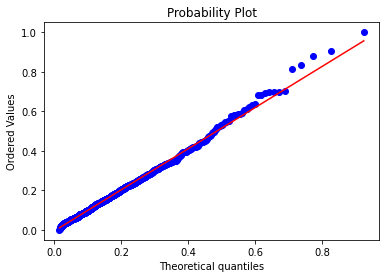

In [46]:
st.probplot(apple_volumes, dist=st.gamma(*args_mle), plot=plt)
plt.show()
st.probplot(apple_volumes, dist=st.gamma(*args_ls), plot=plt)
plt.show()


In [12]:
print(st.kstest(apple_volumes, lambda x: st.gamma.cdf(x, *args_mle)))
print(st.kstest(apple_volumes, lambda x: st.gamma.cdf(x, *args_ls)))
print(st.cramervonmises(apple_volumes, lambda x: st.gamma.cdf(x, *args_mle)))
print(st.cramervonmises(apple_volumes, lambda x: st.gamma.cdf(x, *args_ls)))

KstestResult(statistic=0.03631885044772171, pvalue=0.07044702468162556)
KstestResult(statistic=0.015413839900873194, pvalue=0.9212779324899317)
CramerVonMisesResult(statistic=0.3464145592724243, pvalue=0.10054861996123299)
CramerVonMisesResult(statistic=0.04507049922922192, pvalue=0.9055261702674833)


## Apple prices data

### EM algorithm is applied under the hood since direct optimization of likelihood function is impossible, as well as application of least squares method.

In [60]:
K = 5

mix = GaussianMixture(n_components=K, random_state=1).fit(apple_prices_open.to_numpy().reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

x = np.linspace(apple_prices_open.min(), apple_prices_open.max(), num=100)
pdf = mix_pdf(x, pi, mu, sigma)

In [62]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, figsize=(8, 8))
sns.histplot(apple_prices_open,bins=20, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with Gaussian mixture')
sns.boxplot(x=apple_prices_open, ax=ax_box)
ax_box.set(xlabel='')
ax_hist.legend()
plt.show()

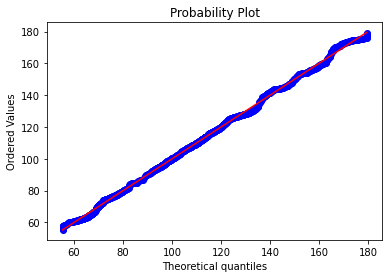

In [63]:
cdf_lambda = lambda x: mix_cdf(x, pi, mu, sigma)
quantile_func = inversefunc(cdf_lambda, domain=[apple_prices_open.min(), apple_prices_open.max()], image=[0, 1])
st.probplot(apple_prices_open, dist=DistWrapper(quantile_func), plot=plt)
plt.show()

In [64]:
print(st.kstest(apple_prices_open, cdf_lambda))
print(st.cramervonmises(apple_prices_open, cdf_lambda))

KstestResult(statistic=0.02327057080457104, pvalue=0.495645776644811)
CramerVonMisesResult(statistic=0.08249323458939735, pvalue=0.6776466288133443)


## Exxon prices data

In [69]:
K = 4
mix = GaussianMixture(n_components=K, random_state=1, max_iter=100).fit(exxon_close.to_numpy().reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

x = np.linspace(exxon_close.min(), exxon_close.max(), 100)
pdf = mix_pdf(x, pi, mu, sigma)

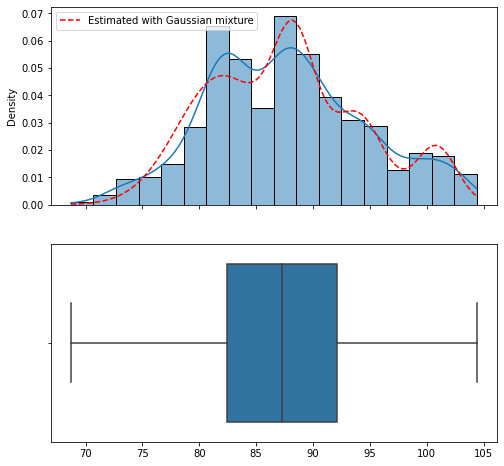

In [70]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, figsize=(8, 8))
sns.histplot(exxon_close, bins=18, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with Gaussian mixture')
sns.boxplot(x=exxon_close, ax=ax_box)
ax_box.set(xlabel='')
ax_hist.legend()
plt.show()

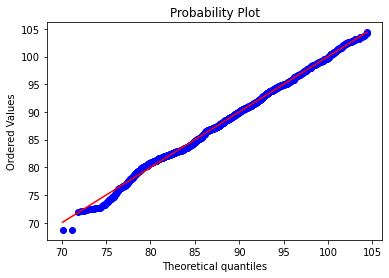

In [72]:
cdf_lambda = lambda x: mix_cdf(x, pi, mu, sigma)
quantile_func = inversefunc(cdf_lambda, domain=[exxon_close.min(), exxon_close.max()], image=[0, 1])
st.probplot(exxon_close, dist=DistWrapper(quantile_func), plot=plt)
plt.show()

In [73]:
print(st.kstest(exxon_close, cdf_lambda))
print(st.cramervonmises(exxon_close, cdf_lambda))

KstestResult(statistic=0.03802791829742519, pvalue=0.05109366280244154)
CramerVonMisesResult(statistic=0.22030817969982766, pvalue=0.23136467227688928)


## JP Morgan prices data

In [74]:
K = 2
mix = GaussianMixture(n_components=K, random_state=1, max_iter=100).fit(jp_morgan_high.to_numpy().reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

x = np.linspace(jp_morgan_high.min(), jp_morgan_high.max(), 100)
pdf = mix_pdf(x, pi, mu, sigma)

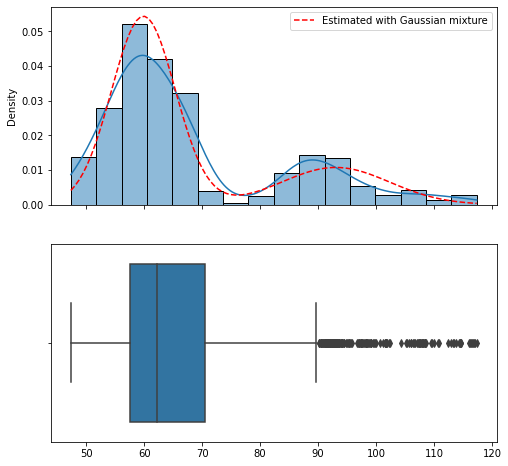

In [75]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, figsize=(8, 8))
sns.histplot(jp_morgan_high, bins=16, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with Gaussian mixture')
sns.boxplot(x=jp_morgan_high, ax=ax_box)
ax_box.set(xlabel='')
ax_hist.legend()
plt.show()

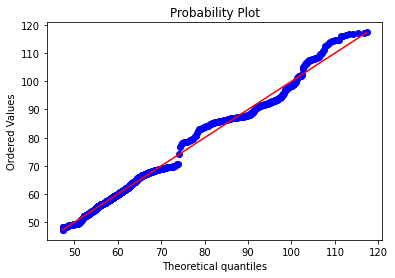

In [76]:
cdf_lambda = lambda x: mix_cdf(x, pi, mu, sigma)
quantile_func = inversefunc(cdf_lambda, domain=[jp_morgan_high.min(), jp_morgan_high.max()], image=[0, 1])
st.probplot(jp_morgan_high, dist=DistWrapper(quantile_func), plot=plt)
plt.show()

In [77]:
print(st.kstest(jp_morgan_high, cdf_lambda))
print(st.cramervonmises(jp_morgan_high, cdf_lambda))

KstestResult(statistic=0.03606609261679883, pvalue=0.07378171451504567)
CramerVonMisesResult(statistic=0.23341992320782728, pvalue=0.21109841011849773)


## Campbell soup volume data

In [81]:
x = np.linspace(campbell_soup_volumes.min(), campbell_soup_volumes.max(), 100)
args_mle = st.gamma.fit(campbell_soup_volumes)
pdf = st.gamma.pdf(x, *args_mle)

In [82]:
quantiles_true = np.quantile(campbell_soup_volumes, q)
args_ls = least_squares(loss_for_least_squares, (1.0, 1.0, 1.0))['x']
pdf_ls = st.gamma.pdf(x, *args_ls)

In [83]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, figsize=(8, 8))
sns.histplot(campbell_soup_volumes, bins=16, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with Gamma distribution')
ax_hist.plot(x, pdf_ls, 'g.', label='Estimated with LS and Gamma distribution')
sns.boxplot(x=campbell_soup_volumes, ax=ax_box)
ax_box.set(xlabel='')
ax_hist.legend()
plt.show()

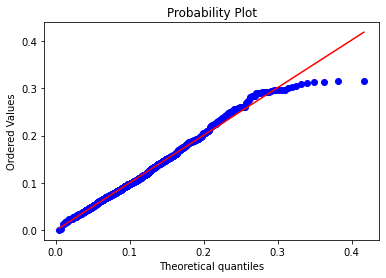

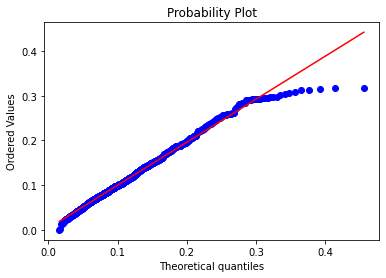

In [84]:
st.probplot(campbell_soup_volumes, dist=st.gamma(*args_mle), plot=plt)
plt.show()
st.probplot(campbell_soup_volumes, dist=st.gamma(*args_ls), plot=plt)
plt.show()

In [85]:
print(st.kstest(campbell_soup_volumes, lambda x: st.gamma.cdf(x, *args_mle)))
print(st.kstest(campbell_soup_volumes, lambda x: st.gamma.cdf(x, *args_ls)))
print(st.cramervonmises(campbell_soup_volumes, lambda x: st.gamma.cdf(x, *args_mle)))
print(st.cramervonmises(campbell_soup_volumes, lambda x: st.gamma.cdf(x, *args_ls)))

KstestResult(statistic=0.02972917575554279, pvalue=0.22617372797184854)
KstestResult(statistic=0.018845263569138238, pvalue=0.7712882147771666)
CramerVonMisesResult(statistic=0.16186286571160535, pvalue=0.3554051073606388)
CramerVonMisesResult(statistic=0.07750435209982891, pvalue=0.7065028217159774)
